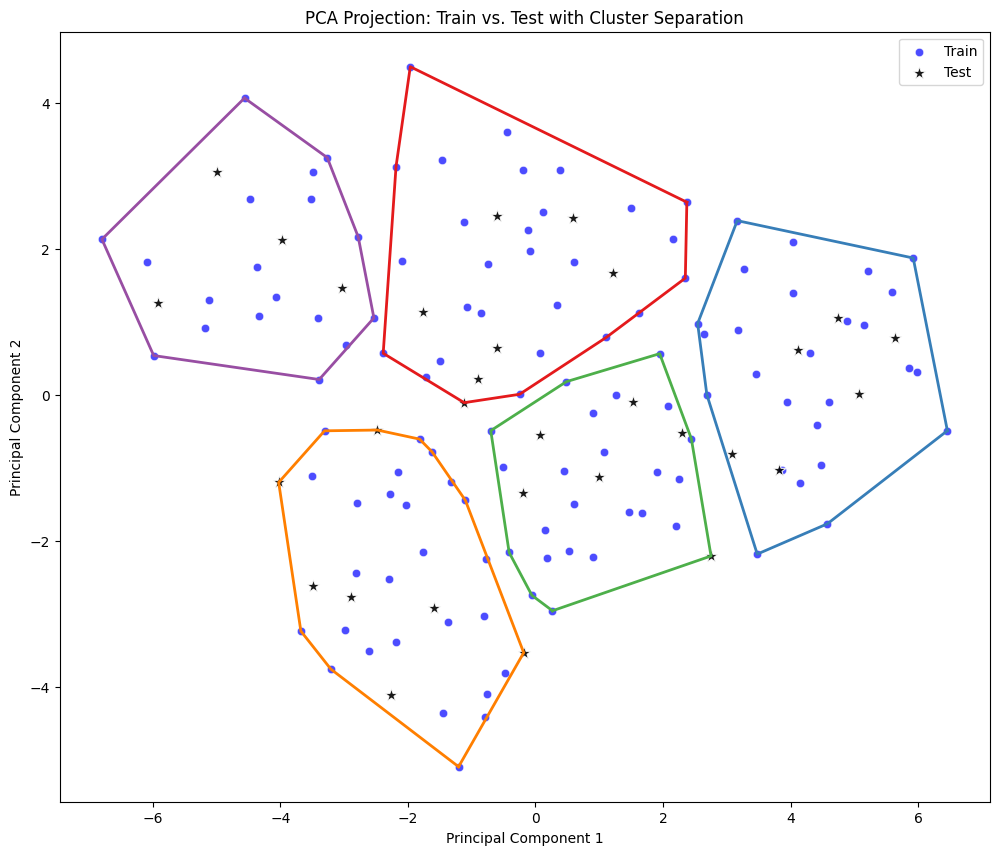

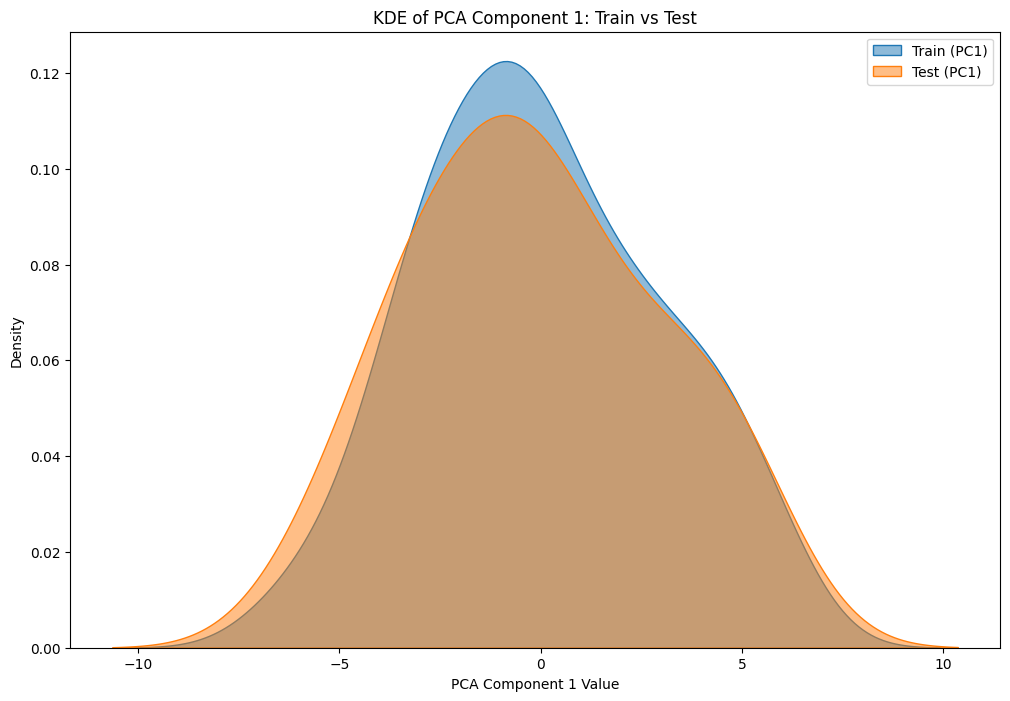

KS Statistic: 0.0583
P-value: 9.9999e-01
 Train-test distribution is acceptable based on KS statistic.
Selected feature: CT_f_e_conn, MSE: 0.00014040782968691254
Selected feature: CT_f_A_tort1, MSE: 8.703885019904607e-05
Selected feature: DISS_wf10_D, MSE: 7.064656532788965e-05
Selected feature: CT_e_D_An, MSE: 6.966443583670337e-05
Selected feature: CT_f_D_tort1, MSE: 6.833400100347087e-05
Selected feature: STAT_CC_A, MSE: 6.797274749857968e-05
Selected features: ['CT_f_e_conn', 'CT_f_A_tort1', 'DISS_wf10_D', 'CT_e_D_An', 'CT_f_D_tort1', 'STAT_CC_A']
Best hyperparameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Test MSE: 5.863439207971731e-05
Test R2: 0.8999202130493693
Train MSE: 1.1063534351465843e-05
Train R2: 0.9790965170052288
Feature: CT_f_e_conn, Importance: 0.802122322388384
Feature: CT_f_A_tort1, Importance: 0.07339599784903034
Feature: DISS_wf10_D, Importance: 0.029250641993384646
Feature: CT_e_D_An, Importance: 0.07396486711586864

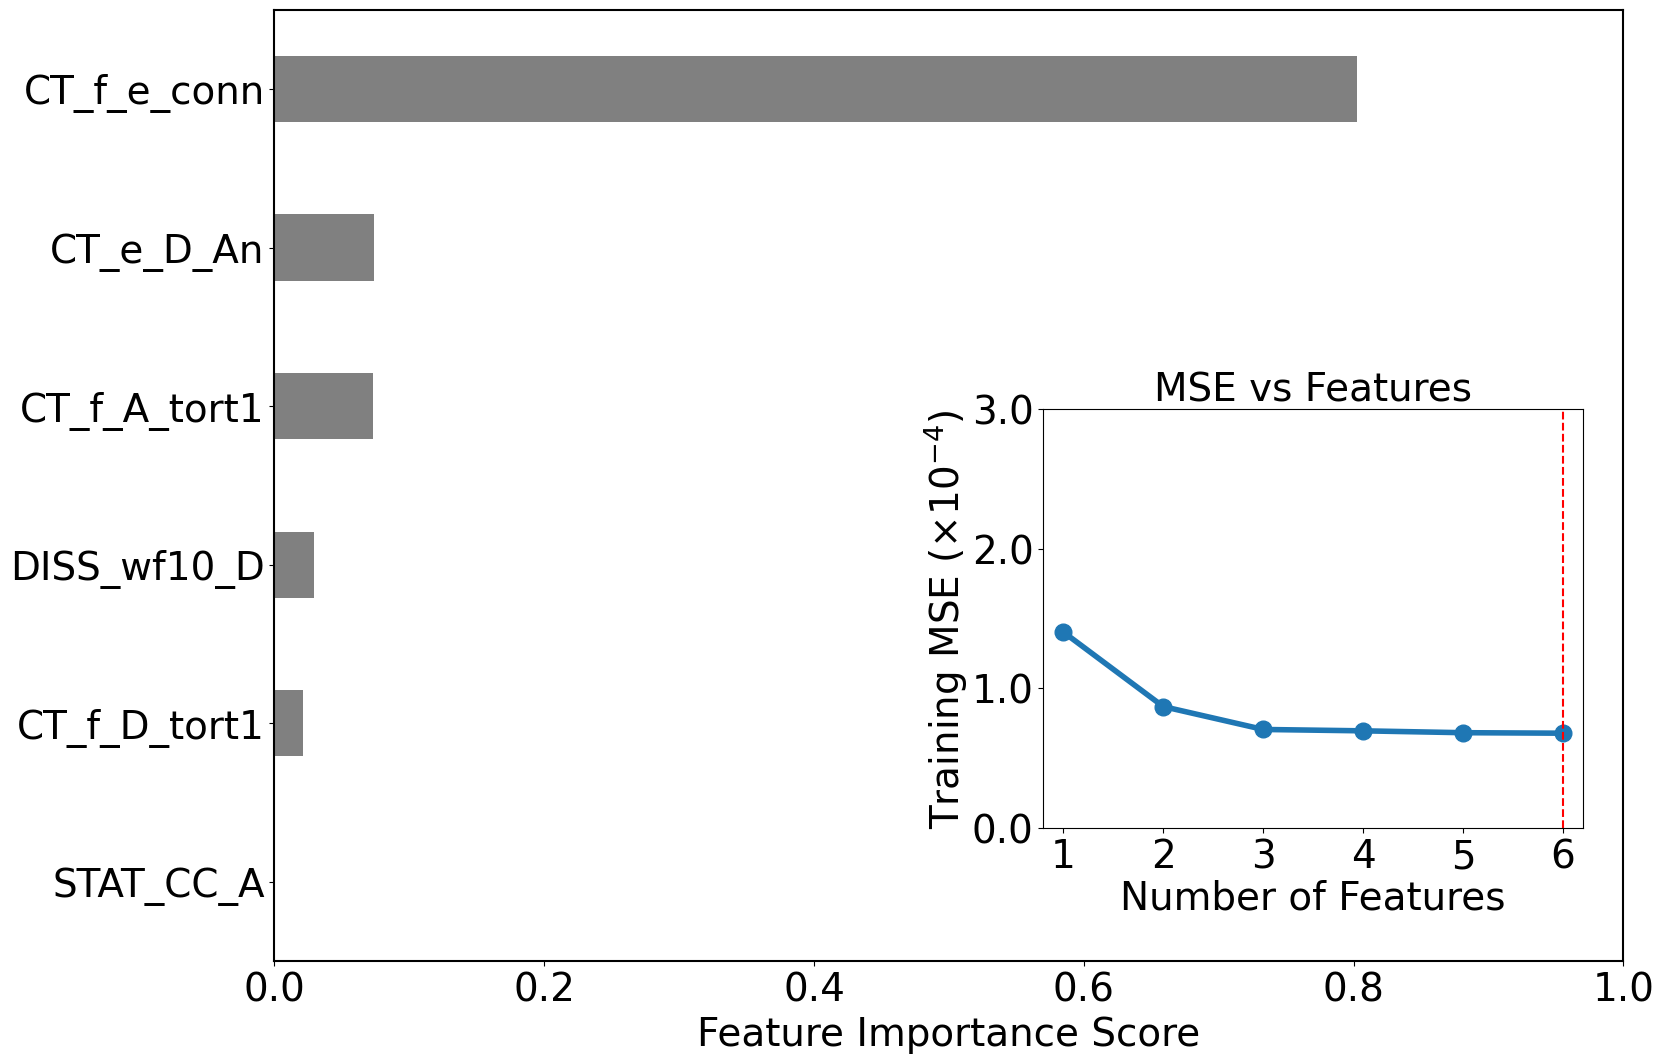

<Figure size 640x480 with 0 Axes>

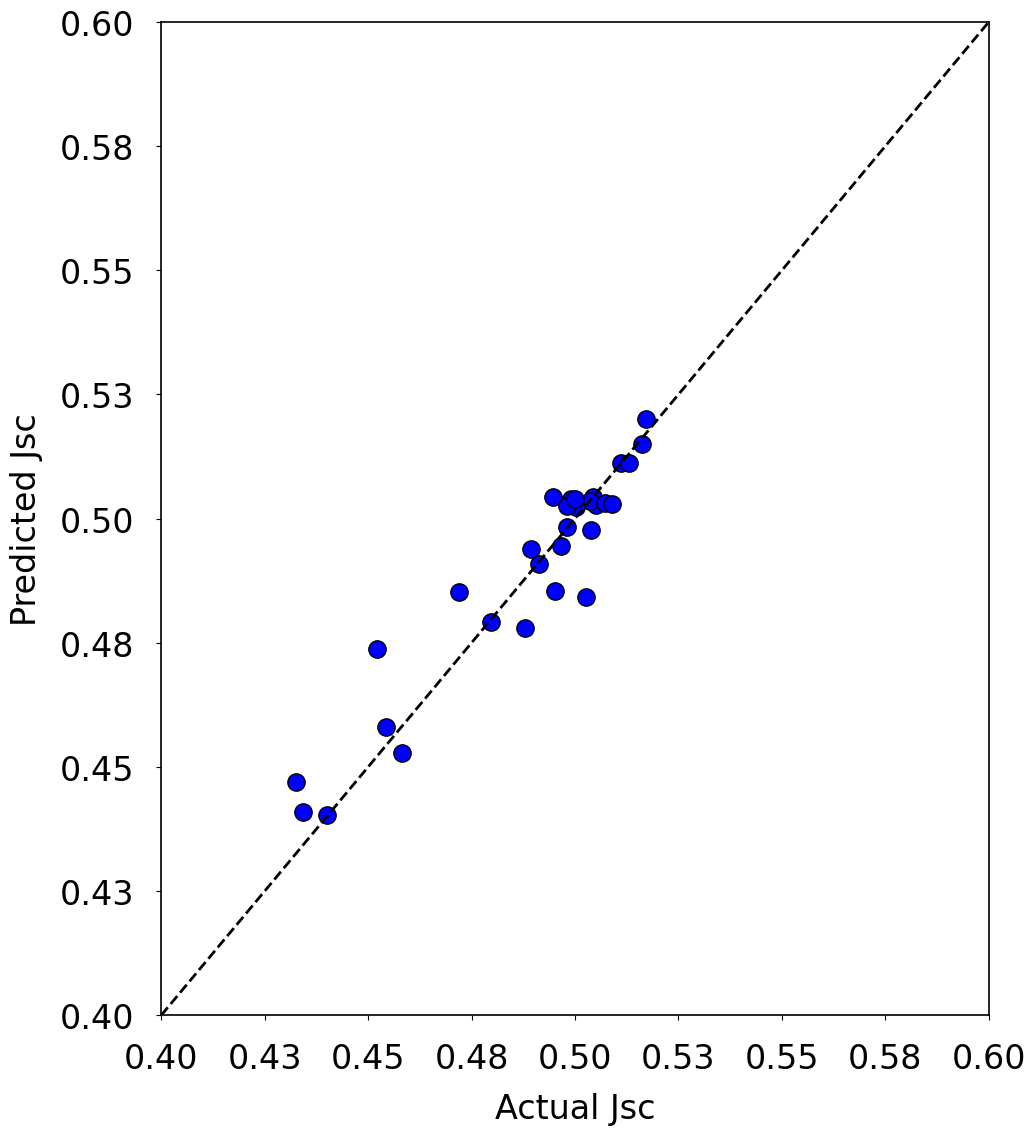

<Figure size 640x480 with 0 Axes>

In [6]:
# ------------------------------------------------------------------------------
# Morphology-to-Performance Prediction for OPV Devices
#
# This notebook implements a Random Forest-based regression pipeline to predict
# Jsc and Fill Factor (FF) from 3D morphology descriptors using forward feature
# selection and stratified training/testing.
#
# Method Overview:
# # 1. Standardize input features and target values for clustering.
#    (Note: the target values will be reversed to their original scale later.)
# 2. Apply KMeans clustering (k=5) to ensure diverse morphology types
# 3. Perform cluster-stratified train-test split (80/20)
# 4. Run forward feature selection on train dataset using 5-fold CV to minimize MSE
# 5. Train Random Forest using selected features and tune hyperparameters
# 6. Evaluate final model on held-out test set (R² and MSE)
#
# Inputs:
# - Morphology descriptor CSVs for P3HT:PCBM and PM6:Y6 (Jsc or FF)
#
# Output:
# - Feature importance ranking
# - Parity plots (Actual vs Predicted)
#
# Note: Customize file paths and target selection manually in the notebook cells.
# ------------------------------------------------------------------------------

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, gaussian_kde
from scipy.stats import wasserstein_distance
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import plotly.express as px
from google.colab import files
from matplotlib.ticker import FuncFormatter

# Load dataset
data = pd.read_csv('graspi_features_corset150_ff_p3htpcbm.csv')
data.dropna(inplace=True)

# Separate features and target
features = data.columns[1:-1]
X = data[features]
y = data['FF(P3HT:PCBM)']
#y = data['Jsc(PM6:Y6)']
#y = data['Jsc(P3HT:PCBM)']
#y = data['FF(PM6:Y6)']


# Convert target to NumPy array safely
y_array = np.array(y).reshape(-1, 1)

# Standardize both features and target together before clustering
scaler_XY = StandardScaler()
X_y_scaled = scaler_XY.fit_transform(np.hstack((X, y_array)))  # Stack features + target


#-------------------------------------------------------------------------------------------------------------------------------------------
# Apply KMeans clustering on the standardized space

# Random_state for kmeans and random_state for tarin_test split is set to 1 and 42 respectively
# For violion plot 100 random seeds combination considered (10 for k_mean and 10 for train_test split): 42,77,123,999,0,1,2024,1234,8080,888
#--------------------------------------------------------------------------------------------------------------------------------------------

kmeans = KMeans(n_clusters=5, random_state=1, n_init=10)
labels = kmeans.fit_predict(X_y_scaled)  # Cluster based on standardized features + target

# Perform stratified train-test split using the cluster labels
X_train_scaled, X_test_scaled, y_train, y_test, train_labels, test_labels = train_test_split(
    X_y_scaled[:, :-1], y, labels, test_size=0.2, stratify=labels, random_state=42
  )

#-------------------------------------------------------------------
#  Apply PCA on the full (features + target) space for visualization
#--------------------------------------------------------------------
# Combine features + target for PCA visualization
X_train_full = np.hstack((X_train_scaled, y_train.to_numpy().reshape(-1, 1)))
X_test_full = np.hstack((X_test_scaled, y_test.to_numpy().reshape(-1, 1)))

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_full)
X_test_pca = pca.transform(X_test_full)

# Combine for visualization
X_pca_combined = np.vstack((X_train_pca, X_test_pca))
labels_combined = np.concatenate((train_labels, test_labels))
split_labels = ["Train"] * len(X_train_pca) + ["Test"] * len(X_test_pca)

# Convert to DataFrame
df_pca = pd.DataFrame(X_pca_combined, columns=["PC1", "PC2"])
df_pca["Cluster"] = labels_combined
df_pca["Set"] = split_labels

#--------------------------------------------------------
# Plot PCA with clusters and Convex  Hulls features+target
#--------------------------------------------------------

plt.figure(figsize=(12, 10))

# Plot Convex Hulls to outline clusters
unique_clusters = np.unique(labels_combined)
colors = sns.color_palette("Set1", len(unique_clusters))

for i, cluster in enumerate(unique_clusters):
    points = df_pca[df_pca["Cluster"] == cluster][["PC1", "PC2"]].values
    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        hull_vertices = np.append(hull.vertices, hull.vertices[0])  # Close the shape
        plt.plot(points[hull_vertices, 0], points[hull_vertices, 1], color=colors[i], linewidth=2)

# Plot train/test points
sns.scatterplot(data=df_pca[df_pca["Set"] == "Train"], x="PC1", y="PC2", color="blue", marker="o", label="Train", alpha=0.7)
sns.scatterplot(data=df_pca[df_pca["Set"] == "Test"], x="PC1", y="PC2", color="black", marker="*", label="Test", alpha=0.9, s=100)

plt.title("PCA Projection: Train vs. Test with Cluster Separation")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(False)
plt.legend()


#--------------------------------------------------------------------------
# KDE and kS with (features+target)  for test-tarin distribution
# Take only PCA 1 (greatest variance)
#---------------------------------------------------------------------

# X_train_pca obtaned from x_train full which includes both features+target value
# Use PC1 only
pc1_train = X_train_pca[:, 0]
pc1_test = X_test_pca[:, 0]

# KDE Plot
plt.figure(figsize=(12, 8))
sns.kdeplot(pc1_train, label="Train (PC1)", fill=True, alpha=0.5)
sns.kdeplot(pc1_test, label="Test (PC1)", fill=True, alpha=0.5)
plt.title("KDE of PCA Component 1: Train vs Test")
plt.xlabel("PCA Component 1 Value")
plt.legend()
plt.grid(False)
plt.show()

# KS Test
ks_stat, p_value = ks_2samp(pc1_train, pc1_test)
print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-value: {p_value:.4e}")

#------------------------------------------------------------------------------------
# Apply KS threshold

# Some random seeds used during the train-test split result in very low test R² scores.
# This section checks whether the test R² is sensitive to differences in the distributions
# of the training and test datasets.
#------------------------------------------------------------------------------------

if ks_stat <= 0.3500:
    print(" Train-test distribution is acceptable based on KS statistic.")
else:
    print(" Warning: The selected random seed results in a significant distribution shift between train and test sets.")
    print(" Consider changing the random seed to achieve a better feature + target distribution balance.")



# Reverse the standardization of the target variable (since we don't standardize `y` for training)
y_train_original = np.array(y_train).reshape(-1, 1)
y_test_original = np.array(y_test).reshape(-1, 1)


#-----------------------------------------------------------------------
# Continue with Feature Selection and Model Training
#-----------------------------------------------------------------------
# Define KFold for cross-validation on the training set
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------------------------------------------------------
# Forward Feature Selection (only on the training data)
# ----------------------------------------------------------------------------

remaining_features = list(features)  # List of all possible feature names
selected_features = []
best_mse = float('inf')
history=[]

while remaining_features:
    mse_with_feature = {}

    for feat in remaining_features:
        # Current candidate set of features
        current_features = selected_features + [feat]

        # Get the *column indices* for these features

        col_indices = [list(features).index(f) for f in current_features]

        # Subset the *scaled* training data columns
        X_sub = X_train_scaled[:, col_indices]

        # Perform KFold cross-validation on (X_sub, y_train)

        fold_mses = []
        y_train_array=np.array(y_train)
        for train_index, val_index in kf.split(X_sub):
            X_tr, X_val = X_sub[train_index], X_sub[val_index]
            y_tr, y_val = y_train_array[train_index], y_train_array[val_index]

            rf_model = RandomForestRegressor(random_state=42)
            rf_model.fit(X_tr, y_tr.ravel())
            y_val_pred = rf_model.predict(X_val)
            fold_mses.append(mean_squared_error(y_val, y_val_pred))

        mse_with_feature[feat] = np.mean(fold_mses)

    # Find which feature gives the best improvement
    best_feature = min(mse_with_feature, key=mse_with_feature.get)
    best_feature_mse = mse_with_feature[best_feature]

    # Check if adding this new feature improves over the previous best MSE
    if best_feature_mse < best_mse:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_mse = best_feature_mse
        print(f"Selected feature: {best_feature}, MSE: {best_mse}")
        #Update history with the number of selected features abd current best MSE
        history.append((len(selected_features), best_mse))
    else:
        # No improvement; stop adding new features
        break

print("Selected features:", selected_features)

# ----------------------------------------------------------------------------
# Hyperparameter Tuning on the *Training Set*
# ----------------------------------------------------------------------------

# Subset scaled training data to the selected features
sel_col_indices = [list(features).index(f) for f in selected_features]
X_train_sel = X_train_scaled[:, sel_col_indices]

# Set up the RandomForestRegressor and parameter grid
#
# The maximum value for n_estimators is capped according to the dataset size
# to improve performance and avoid overfitting.
# Example: for a dataset of size 25 → n_estimators = [2, 5, 10, 20, 25]

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [2, 5, 10,20,25,30,40,50,60,70,75,80,90,100,110,120,130,140,150],
    'max_depth': [1, 2, 3, 5,7],
    'min_samples_split': [2, 5,7],
    'min_samples_leaf': [1, 2, 4],

}

grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_rf.fit(X_train_sel, y_train_original.ravel())
best_rf_model = grid_search_rf.best_estimator_

# Print the best hyperparameters

print("Best hyperparameters:", grid_search_rf.best_params_)

# ----------------------------------------------------------------------------
# Final Evaluation on the *Held-Out* Test Set
# ----------------------------------------------------------------------------

X_test_sel = X_test_scaled[:, sel_col_indices]  # same selected columns for test
y_test_pred = best_rf_model.predict(X_test_sel)

final_mse = mean_squared_error(y_test_original, y_test_pred)
final_r2 = r2_score(y_test_original, y_test_pred)

print("Test MSE:", final_mse)
print("Test R2:", final_r2)

y_train_pred = best_rf_model.predict(X_train_sel)

final_mse_T = mean_squared_error(y_train_original, y_train_pred)
final_r2_T = r2_score(y_train_original, y_train_pred)

print("Train MSE:", final_mse_T)
print("Train R2:", final_r2_T)



# Get feature importance for the final selected features
feature_importances = best_rf_model.feature_importances_

# Display feature importance for each selected feature
for feature, importance in zip(selected_features, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")


# Extract feature importances and their corresponding feature names
importance_sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [selected_features[i] for i in importance_sorted_idx]
sorted_importances = feature_importances[importance_sorted_idx]


#--------------------------------------------------
# Plot feature importance bar chart and MSE history
#-------------------------------------------------

# ======= Font Configuration =======
font_family = 'Sans serif'
main_font_size = 28
inset_font_size = 28
title_size = 28
legend_size = 28
tick_label_size = 28

plt.rcParams.update({
    'font.family': font_family,
    'font.size': main_font_size,
    'axes.titlesize': title_size,
    'axes.labelsize': main_font_size,
    'legend.fontsize': legend_size,
    'xtick.labelsize': tick_label_size,
    'ytick.labelsize': tick_label_size,
})

# ======= Dynamic Plot Settings =======
bar_height = 0.05
bar_spacing = 0.12

bar_count = len(sorted_features)
y_positions = [i * bar_spacing for i in range(bar_count)]
fig_height = 12

# ======= Main Plot =======
fig, ax1 = plt.subplots(figsize=(18, fig_height))
ax1.barh(y_positions, sorted_importances, color='gray', alpha=1, height=bar_height)
ax1.set_yticks(y_positions)
ax1.set_yticklabels(sorted_features)
ax1.set_xlabel('Feature Importance Score', labelpad=5)
ax1.tick_params(axis='both', colors='black')
ax1.xaxis.label.set_color('black')
ax1.yaxis.label.set_color('black')
ax1.invert_yaxis()
ax1.grid(False)
ax1.set_xlim(0, 1)


# Set y-limits manually, reversed for top-down importance
buffer = bar_spacing / 2
y_min = min(y_positions) - buffer
y_max = max(y_positions) + buffer
ax1.set_ylim(y_max, y_min)  # Reversed limits = top-down order


for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# ======= Inset Plot =======
inset_width = 0.4
inset_height = 0.44
inset_x = 0.57  #0.53
#inset_y = 0.10 + (bar_count * 0.01) + (inset_font_size / 300)
inset_y=0.14

ax2 = ax1.inset_axes([inset_x, inset_y, inset_width, inset_height])
mse_values = [h[1] for h in history]
scaled_mse = [val * 1e4 for val in mse_values]   #1e4 for ff  for j e2
ax2.plot(range(1, len(scaled_mse) + 1), scaled_mse, marker='o',linewidth=4,markersize=12)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))

# Set axis limits
ax2.set_xlim(0.8, 6.2)
ax2.set_ylim(0, 3.0)

# Force x-axis ticks to show 1,2,3,4,5,6
ax2.set_xticks([1, 2, 3, 4, 5, 6])
ax2.set_xlabel('Number of Features', fontsize=inset_font_size, labelpad=2)
ax2.set_ylabel('Training MSE (×10$^{-4}$)', fontsize=inset_font_size, labelpad=2)  # For FF set  MSE (×10$^{-4}$), for Jsc set MSE ×10$^{-2}$)
ax2.set_title('MSE vs Features', fontsize=title_size)
ax2.tick_params(axis='both', labelsize=inset_font_size)
ax2.axvline(x=len(selected_features), color='red', linestyle='--')   #label='Optimal features'
#ax2.legend(loc="lower left", frameon=False, fontsize=legend_size)
ax2.grid(False)

# ======= Final Display =======
plt.tight_layout(pad=2)
plt.show()
plt.savefig("Feature_Selection_Plot_ff_P3HT:PCBM.pdf", dpi=300)


#-----------------------------------------------------------------------------------
# Plot prediction results (R²): Jsc or FF
#
# Comment out the performance metric you are not using (either Jsc or FF),
# as demonstrated in the code below.
#-----------------------------------------------------------------------------------

# ======= Font Configuration =======
plt.rcParams.update({
    'font.family': 'Sans serif',
    'xtick.labelsize': 28,
    'ytick.labelsize': 28
})

# Create figure
fig, ax = plt.subplots(figsize=(11, 12))

# Scatter plot
ax.scatter(y_test, y_test_pred, color='blue', edgecolor='black', s=155, alpha=1)


#----------------------------------------
# Plot prediction results (R²) : FF
#---------------------------------------
# Red dashed reference line from 0 to 1
ax.plot([0.4, 0.6], [0.4, 0.6], 'k--', label='Ideal', linewidth=2)

# Fixed axis range from 0 to 1  this is for fill factor
ax.set_xlim([0.4, 0.6])
ax.set_ylim([0.4, 0.6])
# Format ticks to 2 decimal places
formatter = FuncFormatter(lambda x, _: f"{x:.2f}")

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

"""
#-----------------------------------------------
#Plot prediction results (R²) : jsc
#-----------------------------------------------

#Red dashed reference line from 0 to 1
ax.plot([0.0, 20], [0.0, 20], 'r--', label='Ideal', linewidth=2)

# Fixed axis range from 0 to 1  this is for fJsc
ax.set_xlim([0.0, 20])
ax.set_ylim([0.0, 20])

# Add more x-ticks from 0 to 20 every 2
ax.set_xticks(np.arange(0, 21, 5))
ax.set_yticks(np.arange(0, 21, 5))

# Format ticks to 2 decimal places
formatter = FuncFormatter(lambda x, _: f"{int(x)}")

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
"""


# Labels and styling
ax.set_xlabel('Actual Jsc', fontsize=24, color='black', labelpad=12)
ax.set_ylabel('Predicted Jsc', fontsize=24, color='black', labelpad=12)
ax.tick_params(axis='both', colors='black', labelsize=24, pad=16)


# Make spines (borders) black
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

# Optional: grid off, white background
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Save as high-quality PDF
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig("ff_p3htpcbm_prediction_plot.pdf", dpi=300)


fig.show()


